In [2]:
# Step 1: Load data and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
marks_df = pd.read_csv("senior_marks.csv")
grants_df = pd.read_csv("grant_data.csv")

# Display basic info to confirm structure
print("Marks data:")
print(marks_df.info())
print(marks_df.head())

print("\nGrant data:")
print(grants_df.info())
print(grants_df.head())


C:\Users\User\AppData\Local\Temp\ipykernel_13272\1793549732.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  marks_df = pd.read_csv("senior_marks.csv")


Marks data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399981 entries, 0 to 399980
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   academic_yr         399981 non-null  int64  
 1   subject_code        399981 non-null  int64  
 2   grade_level         399078 non-null  object 
 3   credit_received     399981 non-null  float64
 4   loi                 399981 non-null  object 
 5   student_nbr_hashed  399981 non-null  int64  
 6   school_nbr_hashed   399981 non-null  int64  
 7   mark                399981 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 24.4+ MB
None
   academic_yr  subject_code grade_level  credit_received loi  \
0         2018           169         30F              1.0   1   
1         2018           108         42S              1.0   1   
2         2018           274         10S              1.0   1   
3         2019             1         10E          

In [3]:
# Merge on student ID and academic year
merged_df = pd.merge(marks_df, grants_df, on=["student_nbr_hashed", "academic_yr"], how="left")

# Keep only French Immersion (110 or 112)
immersion_df = merged_df[merged_df["stu_grant_code"].isin([110, 112])].copy()

# Optional: create a new label column for early/late
def immersion_type(code):
    if code == 110:
        return "Immersion - Early"
    elif code == 112:
        return "Immersion - Late"
    else:
        return "Other"

immersion_df["immersion_type"] = immersion_df["stu_grant_code"].apply(immersion_type)

# Check the result
print("\nImmersion-only data:")
print(immersion_df["immersion_type"].value_counts())
print(immersion_df.head())



Immersion-only data:
immersion_type
Immersion - Early    34034
Immersion - Late       236
Name: count, dtype: int64
      academic_yr  subject_code grade_level  credit_received loi  \
2447         2018             1         10F              1.0   1   
2448         2018            80         10F              1.0   1   
2449         2018            97         15S              0.5   1   
2450         2018           101         10F              1.0   2   
2451         2018           120         10F              1.0   1   

      student_nbr_hashed  school_nbr_hashed_x mark  stu_grant_code  \
2447           -50826676           1422497309  086           110.0   
2448           -50826676           1422497309  091           110.0   
2449           -50826676           1422497309  095           110.0   
2450           -50826676           1422497309  075           110.0   
2451           -50826676           1422497309  072           110.0   

      school_nbr_hashed_y     immersion_type  
2447  

QUESTION 1  


In [4]:
valid_math_codes = [
    3909, 3900, 3907, 3903, 3000, 3001, 3004, 3005,
    3006, 3007, 3008, 3905, 3908, 3940, 3939, 3923, 3918, 3919
]


In [5]:
# Keep only valid math courses
math_df = immersion_df[immersion_df["subject_code"].isin(valid_math_codes)].copy()

# Remove non-numeric or invalid marks (e.g., 'CO', 'IN', 'S')
math_df = math_df[pd.to_numeric(math_df["mark"], errors="coerce").notna()]
math_df["mark"] = math_df["mark"].astype(float)
print(math_df.head())


      academic_yr  subject_code grade_level  credit_received loi  \
2496         2018          3000         40S              1.0   1   
2497         2018          3939         40S              1.0   1   
2900         2018          3000         30S              1.0   1   
2901         2018          3900         45S              0.5   1   
2902         2018          3939         40S              1.0   1   

      student_nbr_hashed  school_nbr_hashed_x   mark  stu_grant_code  \
2496           381411378           1422497309  100.0           110.0   
2497           381411378           1422497309  100.0           110.0   
2900          1985979674           1422497309   99.0           110.0   
2901          1985979674           1422497309   98.0           110.0   
2902          1985979674           1422497309   87.0           110.0   

      school_nbr_hashed_y     immersion_type  
2496         1.422497e+09  Immersion - Early  
2497         1.422497e+09  Immersion - Early  
2900         1.42

In [12]:
# Map loi to readable labels
loi_map = {1: "English Instruction", 2: "French Instruction"}
math_df["loi_label"] = math_df["loi"].map(loi_map)

# Group by language of instruction
loi_stats = math_df.groupby("loi_label")["mark"].agg(["mean", "std", "count"]).reset_index()

print("\nMath performance by language of instruction (Immersion only):")
print(loi_stats)



Math performance by language of instruction (Immersion only):
             loi_label       mean        std  count
0  English Instruction  75.115445  18.278978    641
1   French Instruction  77.102410  16.804498   1826


In [13]:
# Check data types
print(immersion_df['mark'].dtype)

# Convert to numeric (coerce errors to NaN)
immersion_df['mark'] = pd.to_numeric(immersion_df['mark'], errors='coerce')

# Optionally drop rows where 'mark' is NaN after conversion
immersion_df = immersion_df.dropna(subset=['mark'])

# Now define groups again
group1 = immersion_df[immersion_df['loi'] == 1]['mark']
group2 = immersion_df[immersion_df['loi'] == 2]['mark']

# Run t-test again
t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.3f}, p = {p_val:.3e}")


object
Welch's t-test: t = 6.850, p = 7.607e-12


QUESTION 2


In [16]:
# Step 2: Count French courses per student-year
immersion_df = immersion_df.copy()
immersion_df["is_french_course"] = immersion_df["loi"] == 2

french_course_counts = immersion_df.groupby(
    ["student_nbr_hashed", "academic_yr"]
)["is_french_course"].sum().reset_index().rename(columns={"is_french_course": "num_french_courses"})

# Step 3: Calculate average math mark per student-year
# List of math course codes you provided
math_courses = [3909, 3900, 3907, 3903, 3000, 3001, 3004, 3005, 3006,
                3007, 3008, 3905, 3908, 3940, 3939, 3923, 3918, 3919]

# Filter math courses
math_df = immersion_df[immersion_df["subject_code"].isin(math_courses)].copy()

# Convert Mark to numeric, ignoring non-numeric marks
def to_numeric_mark(x):
    try:
        return float(x)
    except:
        return None

math_df["mark_numeric"] = math_df["mark"].apply(to_numeric_mark)
math_df = math_df.dropna(subset=["mark_numeric"])

avg_math_marks = math_df.groupby(
    ["student_nbr_hashed", "academic_yr"]
)["mark_numeric"].mean().reset_index().rename(columns={"mark_numeric": "avg_math_mark"})

# Merge counts and averages
result_df = pd.merge(avg_math_marks, french_course_counts, on=["student_nbr_hashed", "academic_yr"], how="left")

print(result_df.head())


   student_nbr_hashed  academic_yr  avg_math_mark  num_french_courses
0         -2144821644         2020           67.0                   0
1         -2140243728         2019           60.0                   0
2         -2140243728         2020           67.0                   5
3         -2134519352         2018           58.0                   3
4         -2134519352         2019           53.0                   0


In [17]:
num_students = result_df["student_nbr_hashed"].nunique()
print(f"Number of unique students: {num_students}")


Number of unique students: 1581


    num_french_courses  count_students  mean_math_mark  std_math_mark
0                    0             638       75.027634      18.142045
1                    1              86       77.136364      15.798430
2                    2             140       74.465517      17.643087
3                    3             249       72.446105      16.428038
4                    4             356       75.187066      15.850671
5                    5             379       76.862012      15.977287
6                    6             323       77.993137      16.512888
7                    7             161       81.444123      14.510491
8                    8             106       78.194690      15.329482
9                    9              49       79.457516      16.615316
10                  10              11       87.250000       8.996211
11                  11               6       85.928571      13.706533
12                  12               2       86.500000       4.949747


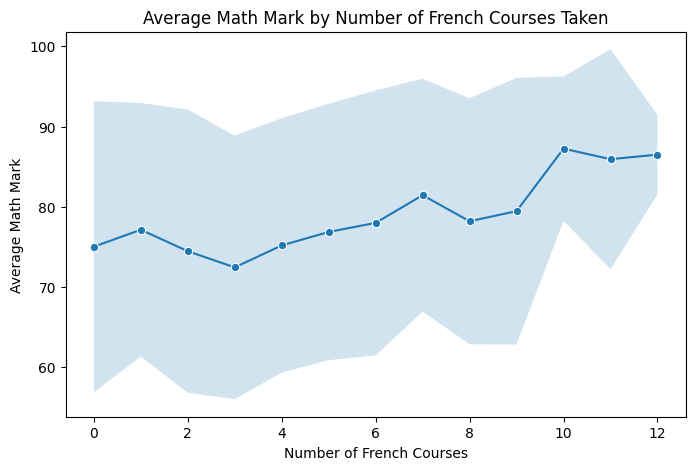

Pearson correlation: 0.097, p-value: 3.647e-07


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# 1. Group summary: mean math mark by number of French courses
summary = result_df.groupby("num_french_courses").agg(
    count_students=("student_nbr_hashed", "nunique"),
    mean_math_mark=("avg_math_mark", "mean"),
    std_math_mark=("avg_math_mark", "std")
).reset_index()

print(summary)

# 2. Plot mean math mark by number of French courses
plt.figure(figsize=(8,5))
sns.lineplot(data=summary, x="num_french_courses", y="mean_math_mark", marker="o")
plt.fill_between(
    summary["num_french_courses"],
    summary["mean_math_mark"] - summary["std_math_mark"],
    summary["mean_math_mark"] + summary["std_math_mark"],
    alpha=0.2
)
plt.xlabel("Number of French Courses")
plt.ylabel("Average Math Mark")
plt.title("Average Math Mark by Number of French Courses Taken")
plt.show()

# 3. Pearson correlation between number of French courses and math mark
# Remove rows with NaN if any
clean_df = result_df.dropna(subset=["num_french_courses", "avg_math_mark"])

corr, pval = pearsonr(clean_df["num_french_courses"], clean_df["avg_math_mark"])
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3e}")


QUESTION 3

Pearson correlation: 0.424, p-value: 2.456e-38


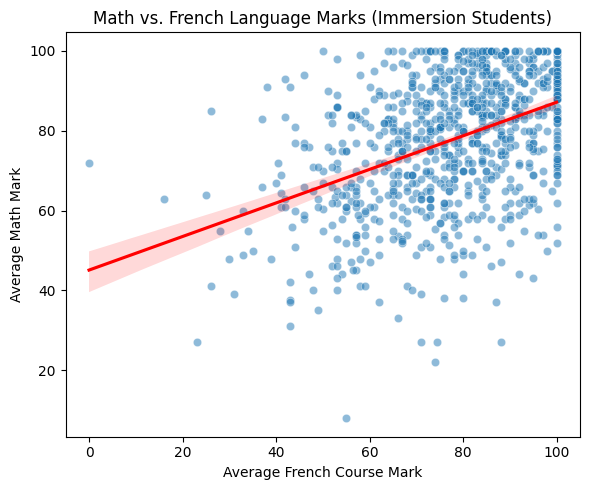

In [20]:
# Step 1–2: Filter mandatory French language courses (subject 401, taught in French)
french_lang_df = immersion_df[
    (immersion_df["subject_code"] == 401) & (immersion_df["loi"] == 2)
].copy()

# Step 3: Clean and convert mark to numeric
def to_numeric_mark(x):
    try:
        return float(x)
    except:
        return None

french_lang_df["mark_numeric"] = french_lang_df["mark"].apply(to_numeric_mark)
french_lang_df = french_lang_df.dropna(subset=["mark_numeric"])

# Step 4: Average French mark per student-year
avg_french_marks = french_lang_df.groupby(
    ["student_nbr_hashed", "academic_yr"]
)["mark_numeric"].mean().reset_index().rename(columns={"mark_numeric": "avg_french_mark"})

# Step 5: Merge with previously computed average math marks
math_french_df = pd.merge(
    avg_math_marks, avg_french_marks, on=["student_nbr_hashed", "academic_yr"], how="inner"
)

# Step 6: Correlation + visualization
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Drop any missing values
math_french_df = math_french_df.dropna(subset=["avg_math_mark", "avg_french_mark"])

# Correlation
corr, pval = pearsonr(math_french_df["avg_french_mark"], math_french_df["avg_math_mark"])
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3e}")

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(data=math_french_df, x="avg_french_mark", y="avg_math_mark", alpha=0.5)
sns.regplot(data=math_french_df, x="avg_french_mark", y="avg_math_mark", scatter=False, color="red")
plt.xlabel("Average French Course Mark")
plt.ylabel("Average Math Mark")
plt.title("Math vs. French Language Marks (Immersion Students)")
plt.tight_layout()
plt.show()


In [21]:
import statsmodels.api as sm

X = sm.add_constant(math_french_df["avg_french_mark"])
y = math_french_df["avg_math_mark"]
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          avg_math_mark   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     185.5
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.46e-38
Time:                        20:14:11   Log-Likelihood:                -3496.2
No. Observations:                 849   AIC:                             6996.
Df Residuals:                     847   BIC:                             7006.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              45.1035      2.435     

In [22]:
# Merge immersion_type into math_french_df
immersion_type_map = immersion_df[["student_nbr_hashed", "academic_yr", "immersion_type"]].drop_duplicates()
math_french_df = pd.merge(math_french_df, immersion_type_map, on=["student_nbr_hashed", "academic_yr"], how="left")

# Compare mean marks by immersion type
type_summary = math_french_df.groupby("immersion_type")[["avg_math_mark", "avg_french_mark"]].agg(["mean", "std", "count"])
print(type_summary)


                  avg_math_mark                  avg_french_mark             \
                           mean        std count            mean        std   
immersion_type                                                                
Immersion - Early     77.470379  16.430647   844       77.149289  16.565972   
Immersion - Late      86.600000  13.501852     5       85.000000  17.958285   

                         
                  count  
immersion_type           
Immersion - Early   844  
Immersion - Late      5  


QUESTION 4

In [ ]:
# Filter for English courses
english_course_codes = [21, 73, 74, 75, 35, 36, 37]  # Remove leading zeros for consistency
english_df = immersion_df[immersion_df["subject_code"].isin(english_course_codes)].copy()

# Step 3: Convert Mark to numeric
def to_numeric_mark(x):
    try:
        return float(x)
    except:
        return None

english_df["mark_numeric"] = english_df["mark"].apply(to_numeric_mark)
english_df = english_df.dropna(subset=["mark_numeric"])

# Step 4: Average English mark per student-year
avg_english_marks = english_df.groupby(
    ["student_nbr_hashed", "academic_yr"]
)["mark_numeric"].mean().reset_index().rename(columns={"mark_numeric": "avg_english_mark"})

# Step 5: Merge with math averages
math_english_df = pd.merge(
    avg_math_marks, avg_english_marks, on=["student_nbr_hashed", "academic_yr"], how="inner"
)

# Step 6: Correlation
from scipy.stats import pearsonr
corr, pval = pearsonr(math_english_df["avg_english_mark"], math_english_df["avg_math_mark"])
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3e}")



Pearson correlation: 0.392, p-value: 4.912e-35


In [25]:
import statsmodels.api as sm

X = sm.add_constant(math_english_df["avg_english_mark"])
y = math_english_df["avg_math_mark"]
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          avg_math_mark   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     166.0
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           4.91e-35
Time:                        20:30:55   Log-Likelihood:                -3760.0
No. Observations:                 919   AIC:                             7524.
Df Residuals:                     917   BIC:                             7534.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.0650      2.583  

QUESTION 5  

In [28]:
import pandas as pd
from scipy.stats import ttest_ind

# Step 1: Define math course codes
math_codes = [3909, 3900, 3907, 3903, 3000, 3001, 3004, 3005, 3006, 
              3007, 3008, 3905, 3908, 3940, 3939, 3923, 3918, 3919]

# Step 2: Filter for math courses
math_df = immersion_df[immersion_df["subject_code"].isin(math_codes)].copy()

# Step 3: Convert marks to numeric
def to_numeric(x):
    try:
        return float(x)
    except:
        return None

math_df["mark_numeric"] = math_df["mark"].apply(to_numeric)
math_df = math_df.dropna(subset=["mark_numeric"])

# Step 4: Group by student and immersion type → get average math mark
avg_math_by_type = math_df.groupby(["student_nbr_hashed", "academic_yr", "immersion_type"])["mark_numeric"].mean().reset_index()

# Step 5: Split into Early and Late groups
early = avg_math_by_type[avg_math_by_type["immersion_type"] == "Immersion - Early"]["mark_numeric"]
late = avg_math_by_type[avg_math_by_type["immersion_type"] == "Immersion - Late"]["mark_numeric"]

# Step 6: Summary stats
print("Early Immersion:", f"mean = {early.mean():.2f}, std = {early.std():.2f}, n = {len(early)}")
print("Late Immersion:", f"mean = {late.mean():.2f}, std = {late.std():.2f}, n = {len(late)}")

# Step 7: Welch’s t-test
t_stat, p_val = ttest_ind(early, late, equal_var=False)
print(f"\nWelch's t-test: t = {t_stat:.3f}, p = {p_val:.3e}")


Early Immersion: mean = 76.16, std = 16.80, n = 2734
Late Immersion: mean = 80.53, std = 15.41, n = 15

Welch's t-test: t = -1.096, p = 2.913e-01


In [31]:
def extract_grade(grade_code):
    try:
        first_digit = int(str(grade_code)[0])
        return 8 + first_digit  # 1 → 9, 2 → 10, 3 → 11, 4 → 12
    except:
        return None

immersion_df["grade_year"] = immersion_df["grade_level"].apply(extract_grade)


In [32]:
math_codes = [3909, 3900, 3907, 3903, 3000, 3001, 3004, 3005, 3006,
              3007, 3008, 3905, 3908, 3940, 3939, 3923, 3918, 3919]

math_df = immersion_df[
    (immersion_df["subject_code"].isin(math_codes)) &
    (immersion_df["grade_year"].isin([9, 10, 11, 12]))
].copy()


In [34]:
avg_math_by_grade = math_df.groupby(
    ["student_nbr_hashed", "academic_yr", "grade_year"]
)["mark"].mean().reset_index()


In [36]:
group_9 = avg_math_by_grade[avg_math_by_grade["grade_year"] == 9]["mark"]
group_10 = avg_math_by_grade[avg_math_by_grade["grade_year"] == 10]["mark"]
group_11 = avg_math_by_grade[avg_math_by_grade["grade_year"] == 11]["mark"]
group_12 = avg_math_by_grade[avg_math_by_grade["grade_year"] == 12]["mark"]

print("Group sizes:")
print("Grade 9:", len(group_9))
print("Grade 10:", len(group_10))
print("Grade 11:", len(group_11))
print("Grade 12:", len(group_12))


Group sizes:
Grade 9: 137
Grade 10: 1047
Grade 11: 890
Grade 12: 853


In [38]:
import pingouin as pg

welch_result = pg.welch_anova(dv='mark', between='grade_year', data=avg_math_by_grade)
print("Welch's ANOVA result:\n", welch_result)


Welch's ANOVA result:
        Source  ddof1       ddof2         F     p-unc       np2
0  grade_year      3  606.498679  3.188959  0.023331  0.003279


In [40]:
import pingouin as pg

# Run Games-Howell post-hoc test
posthoc = pg.pairwise_gameshowell(dv='mark', between='grade_year', data=avg_math_by_grade)

print(posthoc)



    A   B    mean(A)    mean(B)      diff        se         T           df  \
0   9  10  77.072993  76.579433  0.493559  1.589552  0.310502   172.203670   
1   9  11  77.072993  74.974345  2.098648  1.610802  1.302859   181.294552   
2   9  12  77.072993  77.412759 -0.339766  1.592456 -0.213360   173.354439   
3  10  11  76.579433  74.974345  1.605089  0.796980  2.013964  1868.379809   
4  10  12  76.579433  77.412759 -0.833326  0.759216 -1.097613  1871.556298   
5  11  12  74.974345  77.412759 -2.438414  0.802756 -3.037552  1732.520535   

       pval    hedges  
0  0.989589  0.028568  
1  0.562300  0.118693  
2  0.996557 -0.021149  
3  0.183115  0.091982  
4  0.691044 -0.050163  
5  0.012925 -0.145138  
